<div>
     <div>
        <img src="./report/isel_logo.png" width="400" height="400" align="left">
    </div>
    <div>
        <h2>Área Departamental de Engenharia de Eletrónica e Telecomunicações e de Computadores</h2>
        <p>Trabalho prático 4</p>
        <p>Autor:	44598	André L. A. Q. de Oliveira</p>
        <p>Unidade Curricular Compressão de Sinais Multimédia</p>
        <p>Professor: André Lourenço</p>
        <p>27 - Junho - 2021</p>
    </div>
</div>

### <a id="index"></a>

# Index
- [Compressão](#compressao)
    - [snr](#snr)
    - [get_symbol_frequency](#get_symbol_frequency)
    - [entropy](#entropy)
    - [energy](#energy)
- [Erro absoluto médio (MAE)](#mae)
- [Utilities](#utilities)
    - [imshow](#imshow)
    - [imshow_with_movement_vector](#imshow_with_movement_vector)
    - [convertFrame2Jpeg](#convertFrame2Jpeg)
    - [subtract_frames](#subtract_frames)
    - [add_frames](#add_frames)
    - [to_macro_blocks](#to_macro_blocks)
    - [from_macro_blocks](#from_macro_blocks)
    - [sortDictionaryValuesByDistance](#sortDictionaryValuesByDistance)
    - [BestMatchResult](#BestMatchResult)
    - [window_best_match](#window_best_match)
    - [full_search](#full_search)
    - [get_match_frame](#get_match_frame)
- [Codificador 1](#codificador_1)
    - [encode_1](#encode_1)
    - [decode_1](#decode_1)
- [Codificador 2](#codificador_2)
    - [encode_2](#encode_2)
    - [decode_2](#decode_2)
- [Codificador 3](#codificador_2)
    - [encode_3](#encode_3)
    - [decode_3](#decode_3)
- [Testes](#testes)
    - [Tabela :: Análise frame a frame](#tabela-analise-frame-a-frame)
    - [Gráficos](#gráficos)
- [Conclusões](#conclusoes)

# Importar bibliotecas

In [1]:
import os
import math
from time import time
import cv2
import numpy as np
import matplotlib.pyplot as plt

cwd = os.getcwd() # current work diretory

<a id="compressao"></a>

# Compressão

A taxa de compressão pode ser cáculada atrás da seguinte expressão matemática:

$$ T_c = \frac{D_o}{D_c} $$

<a id="snr"></a>

## SNR

A relação sinal-ruído compara o nível de um sinal desejado com o nível do ruído. Quanto mais alta for a relação sinal-ruído, menor é o efeito do ruído de fundo sobre a detecção ou medição do sinal.

$$ SNR(Db) = 10\log_{10}\left[\frac{\sum_{l}\sum_{c}I_{ap}(l,c)^2}{\sum_{l}\sum_{c}[I_{ap}(l,c)-I_{or}(l,c)]^2}\right] $$

In [2]:
def snr(I_or, I_ap):
    Pxa = np.sum(I_ap.astype('float')**2)
    Pe = np.sum( (I_ap.astype('float') - I_or.astype('float'))**2 )
    return 10 * np.log10(Pxa / Pe)

<a id="get_symbol_frequency"></a>

## get_symbol_frequency


Lê um ficheiro, símbolo a símbolo, e retorna um dicionário com par chave-valor : símbolo-frequência, onde cada símbolo terá como respondência a sua frequência no ficheiro. 

In [3]:
# return dicionary {symbol : frequency}
def get_symbol_frequency(file):
    d = dict()
    for i in file:
        d[i] = d.setdefault(i, 0) + 1
    return d

<a id="entropy"></a>

## entropy

A entropia mede a quantidade de informação codificada na mensagem, onde quando maior for o valor entrópico, maior será a incerteza.

A entropia da fonte é dada pela seguinte expressão matemática:

$$ H(S) = -\sum_{i=1}^{N}p(s_i)log_{2}p(s_i) $$

In [4]:
def calculate_entropy(symbol_freq_dictionary):
    # list of symbol occurences in file
    occurrences = list(symbol_freq_dictionary.values())
    # total number of symbols
    t = np.sum(occurrences)
    # probability of each symbol
    p = [occ / t for occ in occurrences]
    return -np.sum([p * np.log2(p)])

<a id="efficiency"></a>

## efficiency

A eficiência da condificação pode ser obtida através da seguinte expressão matemática:

$$ \eta = \frac{H(S)}{L} $$

onde, **_L_** é o número médio de bits por símbolo.

É possível codificar uma fonte, sem perdas, se o número médio de bits por símbolo for maior ou igual à entropia da fonte:

$$ H(S) < L < H(S) + \delta $$

In [5]:
def efficiency(H, dictionary):
    # average number of bits per symbol
    L = 0
    for symbol in dictionary:
        L += len(dictionary[symbol])
    L = L / len(dictionary)
    return L, ( H / L )

<a id="energy"></a>

## energy

A energia no contexto deste trabalho é utilizada como uma métrica para determinar a informação numa imagem, ou seja, se uma imagem tem maior energia que outra, irá resultar numa imagem com pouco valores de 0, que no final, após ser aplicada uma transforamção DCT resulta numa imagem com uma compressão mais fraca quando em comparação com outra que tenha menor níveis de energia.

$$ E = \sum_{m=1}^{M}\sum_{n=1}^{N} X{t}(m,n)^2 $$

In [6]:
def energy(image):
    return np.sum(image.ravel()**2)

<a id="mae"></a>

# Erro absoluto médio (MAE)

Critério de semelhança entre blocos

$$ (d_m,d_n) = arg \min_{d_m,d_n} \frac{1}{MN}\sum_{m=1}^{M}\sum_{n=1}^{N} \left| X^{t}(m,n)-X^{t-1}(m-d_m,n-d_n) \right| $$

In [7]:
def mae(b1, b2):
    return np.sum(np.abs(cv2.subtract(b1.astype('float32'),b2.astype('float32')).ravel())) / len(b1.ravel())

In [8]:
block1 = np.ones(256).reshape((16,16))
block2 = (np.ones(256)*3).reshape((16,16))

print(mae(block1, block2))

2.0


[back to index](#index)

<a id="utilities"></a>

# Utilities

<a id="imshow"></a>

## imshow

Função que permite visualizar uma imagem.

In [9]:
def imshow(title, image):
    cv2.imshow(title, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

<a id="imshow_with_movement_vector"></a>

## imshow_with_movement_vector

Função que permite visualizar uma imagem com os vetores de movimento.

In [10]:
def imshow_with_movement_vector(title, image, full_search_result, color):
    
    # Dictionary containing some colors
    colors = {'blue': (255, 0, 0), 'green': (0, 255, 0), 'red': (0, 0, 255), 
          'yellow': (0, 255, 255), 'magenta': (255, 0, 255), 'cyan': (255, 255, 0), 
          'white': (255, 255, 255), 'black': (0, 0, 0), 'gray': (125, 125, 125), 
          'rand': np.random.randint(0, high=256, size=(3,)).tolist(), 'dark_gray': (50, 50, 50), 
          'light_gray': (220, 220, 220)}
    
    image = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)
    
    if color not in colors:
        color = 'rand'
        
    for r in full_search_result.ravel():
        x1 = r.get_from_coord()[1]
        y1 = r.get_from_coord()[0]
        x2 = r.get_to_coord()[1]
        y2 = r.get_to_coord()[0]
        cv2.arrowedLine(image, (x1,y1), (x2,y2), colors[color], 1)
        
    imshow(title, image)
    

<a id="convertFrame2Jpeg"></a>

## convertFrame2Jpeg

Função que executa uma compressão jpeg com qualidade de 50 de uma frame para uma imagem de cinzentos.

In [11]:
def convertFrame2Jpeg(path, frame):
    cv2.imwrite(f"{path}.jpg", frame, (cv2.IMWRITE_JPEG_QUALITY, 50))
    return cv2.imread(f"{path}.jpg", cv2.IMREAD_GRAYSCALE)

<a id="subtract_frames"></a>

## subtract_frames

Calcula a diferença entre duas imagens, e aplica posteriormente uma normalização sobre o resultado, de forma a manter todos os valores uint8.

In [12]:
def subtract_frames(frame, Iframe):
    #return cv2.subtract(frame, Iframe)
    return ( ( frame.astype('int16') - Iframe.astype('int16') ) / 2  + 64 ).astype('uint8')

<a id="add_frames"></a>

## add_frames

Realiza a adição entre duas imagens, e aplica posteriormente uma de-normalização sobre o resultado, de forma a recuperar os valores uint8 originais.

In [13]:
def add_frames(frame, Iframe):
    #return cv2.add(frame, Iframe)
    return ( (frame.astype('int16') - 64)*2 + Iframe.astype('int16') ).astype('uint8')

In [14]:
i_f = cv2.imread(f"{cwd}/input_data/bola_seq/bola_1.tiff", cv2.IMREAD_GRAYSCALE)
print("i_f\n", i_f, "\n")

p_f = cv2.imread(f"{cwd}/input_data/bola_seq/bola_2.tiff", cv2.IMREAD_GRAYSCALE)
print("pf\n", p_f, "\n")

s_f = subtract_frames(p_f, i_f)
print("s_f\n", s_f, "\n")

r_f = add_frames(s_f, i_f)
print("r_f\n", r_f, "\n")

i_f
 [[ 60  62  62 ...  30  32  32]
 [ 68  69  75 ...  31  33  32]
 [ 89  57  58 ...  30  33  32]
 ...
 [ 62  63  62 ...  62  55  28]
 [ 62  64  65 ... 120 119  99]
 [ 65  63  64 ... 119 119 119]] 

pf
 [[ 59  60  65 ...  29  31  32]
 [ 69  71  72 ...  29  32  32]
 [ 98  58  55 ...  29  32  33]
 ...
 [ 62  63  63 ...  69  59  36]
 [ 63  63  62 ... 120 121 107]
 [ 64  64  64 ... 119 119 119]] 

s_f
 [[63 63 65 ... 63 63 64]
 [64 65 62 ... 63 63 64]
 [68 64 62 ... 63 63 64]
 ...
 [64 64 64 ... 67 66 68]
 [64 63 62 ... 64 65 68]
 [63 64 64 ... 64 64 64]] 

r_f
 [[ 58  60  64 ...  28  30  32]
 [ 68  71  71 ...  29  31  32]
 [ 97  57  54 ...  28  31  32]
 ...
 [ 62  63  62 ...  68  59  36]
 [ 62  62  61 ... 120 121 107]
 [ 63  63  64 ... 119 119 119]] 



<a id="to_macro_blocks"></a>

### to_macro_blocks

Divide uma imagem em uma matriz de blocos de tamanho size x size.

In [15]:
def to_macro_blocks(image, size):
    
    width, height = image.shape
    
    if (width % size) != 0 or (height % size) != 0:
        raise Exception('function only supports multiple macro block division!')
    
    macro_blocks = np.zeros((int(width/size), int(height/size)), dtype=object)
    
    i = -1
    j = -1
    for lin in range(0, width, size):
        i += 1
        j = -1
        for col in range(0, height, size):
            j += 1
            # create new block
            macro_blocks[i][j] = image[lin:(lin + size),col:(col  +size)]
                
    return macro_blocks

<a id="from_macro_blocks"></a>

### from_macro_blocks

Merge um matriz de macro blocos para uma imagem.

In [16]:
def from_macro_blocks(matrix, size):
    
    width  = matrix.shape[0] * size
    heigth = matrix.shape[1] * size
    
    output = np.zeros((width, heigth), dtype='uint8')
    
    i = -1
    j = -1
    for lin in range(0, width, size):
        i += 1
        j = -1
        for col in range(0, heigth, size):
            j += 1
            output[lin:(lin+size),col:(col+size)] = matrix[i][j]
    return output

In [17]:
f = np.arange(64).reshape((8,8))
print('f\n', f, "\n")

mb = to_macro_blocks(f, 4)
print('to_macro_blocks\n', mb, "\n")

r_f = from_macro_blocks(mb,4)
print('from_macro_blocks\n', r_f, "\n")

f
 [[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62 63]] 

to_macro_blocks
 [[array([[ 0,  1,  2,  3],
         [ 8,  9, 10, 11],
         [16, 17, 18, 19],
         [24, 25, 26, 27]]) array([[ 4,  5,  6,  7],
                                   [12, 13, 14, 15],
                                   [20, 21, 22, 23],
                                   [28, 29, 30, 31]])]
 [array([[32, 33, 34, 35],
         [40, 41, 42, 43],
         [48, 49, 50, 51],
         [56, 57, 58, 59]]) array([[36, 37, 38, 39],
                                   [44, 45, 46, 47],
                                   [52, 53, 54, 55],
                                   [60, 61, 62, 63]])]] 

from_macro_blocks
 [[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 

[back to index](#index)

<a id="sortDictionaryValuesByDistance"></a>
 
## sortDictionaryValuesByDistance

Ordena um dicionário chave-vale do tipo **dict<(x,y), MAE>**, segundo o critério de próximidade pelo parâmetro de entrada **coord**.

Tem como objetivo, após ordenação, caso existam valores idênticos de erro absoluto médio para várias entradas do dicionário, que estas estejas ordenadas pela próximidade (distância mais curta) de uma dada coordenada.

In [18]:
def sortDictionaryValuesByDistance(d: dict, coord):
    return dict(sorted(d.items(), key=lambda item: math.sqrt((coord[0]-item[0][0])**2 + (coord[1]-item[0][1])**2)))

In [19]:
d = dict()
d[(0,0)] = 3
d[(0,1)] = 7
d[(0,4)] = 6
d[(0,3)] = 2
d[(1,1)] = 2
d[(1,0)] = 1
d[(7,3)] = 1
print(d)

d = sortDictionaryValuesByDistance(d, (1,3))
print(d)

best_key = min(d, key=d.get)
print(best_key)

{(0, 0): 3, (0, 1): 7, (0, 4): 6, (0, 3): 2, (1, 1): 2, (1, 0): 1, (7, 3): 1}
{(0, 3): 2, (0, 4): 6, (1, 1): 2, (0, 1): 7, (1, 0): 1, (0, 0): 3, (7, 3): 1}
(1, 0)


<a id="BestMatchResult"></a>
 
## BestMatchResult

Classe que serve para agrupar informação do resultado da estratégia de procura exaustiva:
* **from_coord:** a coordenada original do canto superior esquerdo do bloco
* **macro_block:** o bloco a procurar na frame de referência 
* **to_coord:** a coordenada da nova posição do bloco, para calcular o vetor de movimento
* **match_block:** o bloco resultante do match com o melhor resultado do erro médio absoluto

In [20]:
class BestMatchResult(object): 
    def __init__(self, from_coord, macro_block, to_coord, match_block):
        self.from_coord = from_coord
        self.macro_block = macro_block
        self.to_coord = to_coord
        self.match_block = match_block

    def get_from_coord(self):
        return self.from_coord
    def get_macro_block(self):
        return self.macro_block 
    def get_to_coord(self):
        return self.to_coord
    def get_match_block(self):
        return self.match_block

<a id="window_best_match"></a>
 
## window_best_match

Para cada macro bloco, vai procurar numa janela de dimensões(x1,y1)(x2,y2) na frame **Iframe** pelo da melhor vetor de movimento, ou seja, o vetor de movimento para o bloco que apresentar menor valor de erro absoluto médio.

Os vetores de movimento são guardados num dicionário, que depois é ordenado pela distância mais curta dessas mesmas coordenadas, ao ponto de origem do macro bloco, de forma a criar um critério de seleção.

A função retorna um **BestMatchResult**, onde o vetor de movimento será dado pelo primeiro valor mínimo do dicionário.

In [21]:
def window_best_match(macroBlock, Iframe, coord, x1, y1, x2, y2):
    
    # block size
    bs = macroBlock.shape[0]
    
    # creates a dictionary to store <coord(x,y), mae value>
    d = dict()
    for l in range(x1, x2): # until
        for c in range(y1, y2): # until
            d[l,c] = mae(macroBlock, Iframe[l:l+bs, c:c+bs])
    
    # sort dicionary values by distance, so the first minimum mae && dist is choosen
    dByDistance = sortDictionaryValuesByDistance(d, coord)
    best_key = min(dByDistance, key=d.get)
    matchBlock = Iframe[best_key[0]:best_key[0]+bs, best_key[1]:best_key[1]+bs]
    
    return BestMatchResult( coord, macroBlock, best_key, matchBlock )

In [22]:
if3 = [[ 0, 0, 0, 0, 0, 0],
       [ 0, 0, 0, 0, 0, 0],
       [ 1, 1, 1, 0, 0, 0],
       [ 1, 1, 1, 0, 0, 0],
       [ 1, 1, 1, 0, 0, 0],
       [ 0, 0, 0, 0, 0, 0]]
if3 = np.array(if3)

# pframe
pf3 = [[ 0, 0, 0, 0, 0, 0],
       [ 0, 0, 0, 0, 0, 0],
       [ 0, 0, 0, 0, 0, 0],
       [ 0, 1, 1, 1, 0, 0],
       [ 0, 1, 1, 1, 0, 0],
       [ 0, 1, 1, 1, 0, 0]]

pf3 = np.array(pf3)
mb = to_macro_blocks(pf3, 2)
print('macro-blocks\n', mb, "\n")
print('macro-blocks[1,1]\n', mb[1,1], "\n")

best_match = window_best_match(mb[1,1], if3, (2,2), 2-1, 2-1, 2+1, 2)
print('best_match-from_coord: ', best_match.get_from_coord(), "\n")
print('best_match-macro_block\n', best_match.get_macro_block(), "\n")
print('best_match-to_coord: ', best_match.get_to_coord(), "\n")
print('best_match-match_block\n', best_match.get_match_block(), "\n")

macro-blocks
 [[array([[0, 0],
         [0, 0]]) array([[0, 0],
                         [0, 0]]) array([[0, 0],
                                         [0, 0]])]
 [array([[0, 0],
         [0, 1]]) array([[0, 0],
                         [1, 1]]) array([[0, 0],
                                         [0, 0]])]
 [array([[0, 1],
         [0, 1]]) array([[1, 1],
                         [1, 1]]) array([[0, 0],
                                         [0, 0]])]] 

macro-blocks[1,1]
 [[0 0]
 [1 1]] 

best_match-from_coord:  (2, 2) 

best_match-macro_block
 [[0 0]
 [1 1]] 

best_match-to_coord:  (1, 1) 

best_match-match_block
 [[0 0]
 [1 1]] 



[back to index](#index)

<a id="full_search"></a>
 
## full_search

Executa uma estratégia de procura exaustiva (FSM). Para cada macro bloco irá procurar numa dada uma janela de dimensões (M x N) pelo bloco mais semelhante presente numa frame de referência. A frame é escolhida pelo bloco que tiver um menor valor de erro absoluto médio.

No final retorna um objeto BestmatchResult, onde entre outras variáveis, se encontra o vetor de movimento.

In [23]:
def full_search(macroBlocks, Iframe, bs, ws):

    best_match = np.empty(macroBlocks.shape, dtype=object)
    
    # full-search
    for i in range(macroBlocks.shape[0]):
        for j in range(macroBlocks.shape[1]):
                
            # width
            w = i * bs
            # height
            h = j * bs

            ### macro block bounderies
            # top
            if i == 0:
                # left corner
                if j == 0:
                    best_match[i,j] = window_best_match(macroBlocks[i,j], Iframe, (w, h), w, h, w+ws, h+ws)
                # right corner
                elif j == (macroBlocks.shape[1] - 1):
                    best_match[i,j] = window_best_match(macroBlocks[i,j], Iframe, (w, h), w, h-ws, w+ws, h)
                # center
                else:
                    best_match[i,j] = window_best_match(macroBlocks[i,j], Iframe, (w, h), w, h-ws, w+ws, h+ws)
            # bottom
            elif i == (macroBlocks.shape[0] - 1):
                # left corner
                if j == 0:
                    best_match[i,j] = window_best_match(macroBlocks[i,j], Iframe, (w, h), w-ws, h, w, h+ws)
                # right corner - eob
                elif j == (macroBlocks.shape[1] - 1):
                    best_match[i,j] = window_best_match(macroBlocks[i,j], Iframe, (w, h),  w-ws, h-ws, w, h)
                # center
                else:
                    best_match[i,j] = window_best_match(macroBlocks[i,j], Iframe, (w, h), w-ws, h-ws, w, h+ws)
            # left
            elif j == 0:
                best_match[i,j] = window_best_match(macroBlocks[i,j], Iframe, (w, h), w-ws, h, w+ws, h+ws)
            # right
            elif j == (macroBlocks.shape[1] - 1):
                best_match[i,j] = window_best_match(macroBlocks[i,j], Iframe, (w, h), w-ws, h-ws, w+ws, h)
            # center
            else:
                best_match[i,j] = window_best_match(macroBlocks[i,j], Iframe, (w, h), w-ws, h-ws, w+ws, h+ws)
                    
    return best_match

In [24]:
fsr = full_search(mb, if3, 2, 2)
for i in range(fsr.shape[0]):
    for j in range(fsr.shape[1]):
        print('best_match-from_coord: ', fsr[i,j].get_from_coord(), "\n")
        print('best_match-macro_block\n', fsr[i,j].get_macro_block(), "\n")
        print('best_match-to_coord: ', fsr[i,j].get_to_coord(), "\n")
        print('best_match-match_block\n', fsr[i,j].get_match_block(), "\n")
        print('--------------------------------------------\n')

best_match-from_coord:  (0, 0) 

best_match-macro_block
 [[0 0]
 [0 0]] 

best_match-to_coord:  (0, 0) 

best_match-match_block
 [[0 0]
 [0 0]] 

--------------------------------------------

best_match-from_coord:  (0, 2) 

best_match-macro_block
 [[0 0]
 [0 0]] 

best_match-to_coord:  (0, 2) 

best_match-match_block
 [[0 0]
 [0 0]] 

--------------------------------------------

best_match-from_coord:  (0, 4) 

best_match-macro_block
 [[0 0]
 [0 0]] 

best_match-to_coord:  (0, 3) 

best_match-match_block
 [[0 0]
 [0 0]] 

--------------------------------------------

best_match-from_coord:  (2, 0) 

best_match-macro_block
 [[0 0]
 [0 1]] 

best_match-to_coord:  (1, 0) 

best_match-match_block
 [[0 0]
 [1 1]] 

--------------------------------------------

best_match-from_coord:  (2, 2) 

best_match-macro_block
 [[0 0]
 [1 1]] 

best_match-to_coord:  (1, 1) 

best_match-match_block
 [[0 0]
 [1 1]] 

--------------------------------------------

best_match-from_coord:  (2, 4) 

best_ma

[back to index](#index)

<a id="get_match_frame"></a>
 
## get_match_frame

A partir de vetores de movimento, cria uma nova frame a reorganizando os macro blocos de uma frame de referência **Iframe**.

In [25]:
def get_match_frame(Iframe, full_search_result):
    
    match_blocks = np.zeros(full_search_result.shape, dtype=object)
    
    # block size  
    bs = full_search_result[0,0].get_macro_block().shape[0]
    
    for i in range(full_search_result.shape[0]):
        for j in range(full_search_result.shape[1]):
            # move to coordinates :: I -> I*
            coord = full_search_result[i,j].get_to_coord()
            match_blocks[i,j] = Iframe[coord[0]:coord[0]+bs, coord[1]:coord[1]+bs]
    
    #imshow("match", from_macro_blocks(match_blocks, bs))
    return from_macro_blocks(match_blocks, bs)

In [26]:
print( get_match_frame(if3, fsr) )

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]]


[back to index](#index)

 <a id="codificador_1"></a>
 
# Codificador 1
 
<div class="alert alert-block alert-info">
Considera que cada frame é uma intra-frame (I).
</div>

In [27]:
def encode_1(path, frame):
    return convertFrame2Jpeg(path, frame)

[back to index](#index)

<a id="codificador_2"></a>
 
# Codificador 2
 
<div class="alert alert-block alert-info">
Considera que todas as frames à exceção da primeira (a I-frame) são inter-frames (P), sem compensação de movimento.
</div>

In [28]:
def encode_2(path, Iframe, Pframe):
    return convertFrame2Jpeg(path, subtract_frames(Pframe, Iframe))

In [29]:
def decode_2(path, Iframe, Sframe):
    return convertFrame2Jpeg(path, add_frames(Sframe, Iframe))

[back to index](#index)

<a id="codificador_3"></a>
 
# Codificador 3
 
<div class="alert alert-block alert-info">
Considera que todas as frames à exceção da primeira (a I-frame) são inter-frames (P), com compensação de movimento.
</div>


<a id="encode_3"></a>
 
## encode_3

A codificação de imagem com compensação de movimento, descreve uma imagem em termos da transformação, neste contexto causada por movimento, de uma frame de referência com uma frame atual.A premissa desta condificação assenta que quando as imagens podem ser sintetizadas com precisão a partir de imagens previamente transmitidas, pode existir um aumento significativo da eficiência da compressão.

* para cada macro bloco de cada inter frame (P) vai-se estimar o vetor de movimento em relação a uma frame de referência (I)
* é codificado o vector de movimento através de uma estratégia de procura exaustiva
* o vetor de movimento é utilizado para calcular uma frame com compensação de movimento em relação a uma frame de referência
* é realizada a diferença entre a frame no instante actual e a frame estimada para o mesmo instante

![jpeg-encoding](./report/encoder-motion-compensation.png)

In [30]:
def encode_3(path, Iframe, Pframe):
    
    # block size
    bs = 16
    # window size
    ws = 15
    
    # divide Pframe into 16x16 macro blocks
    macroBlocks = to_macro_blocks(Pframe, bs)
    full_search_result = full_search(macroBlocks, Iframe, bs, ws)
        
    # calculate the frame with motion compensation
    match_frame = get_match_frame(Iframe, full_search_result)
    Sframe = convertFrame2Jpeg(path, subtract_frames(Pframe, match_frame))
      
    return Sframe, full_search_result

<a id="decode_3"></a>

## decode_3

* processo inverso do encode_3
* a partir do vetor de movimento calcula-se a frame estimada
* adiciona-se a frame estimada com a frame enviada pelo emissor para recuperar a inter frame (P) 

![jpeg-encoding](./report/decoder-motion-compensation.png)

In [31]:
def decode_3(path, Iframe, Sframe, full_search_result):
    match_frame = get_match_frame(Iframe, full_search_result)
    return convertFrame2Jpeg(path, add_frames(Sframe, match_frame))

[back to index](#index)

### <a id="testes"></a>

# Testes

In [32]:
# error() # cause error to stop here, when execute "run all cells" command

## Importar dados

In [33]:
frames = []
frames_size = []
entropy = []

for i in range(len(os.listdir(f"{cwd}/input_data/bola_seq"))):
    frames.append( cv2.imread(f"{cwd}/input_data/bola_seq/bola_{i+1}.tiff", cv2.IMREAD_GRAYSCALE) )
    frames_size.append( os.stat(f"{cwd}/input_data/bola_seq/bola_{i+1}.tiff").st_size )
    entropy.append( calculate_entropy(get_symbol_frequency(frames[i].ravel())) )
    
Iframe = frames[0]
Pframes = frames[1:]

<div class="alert alert-block alert-info">
Codificador 1
</div>

In [35]:
# prepare data with trab4 functions for encode-1
# -- time data
encode_time_1 = []
decode_time_1 = np.empty(len(frames))
decode_time_1[:] = np.nan
# -- compression data
compression_size_1 = []
energy_1 = []
entropy_1 = []
TC_1 = []
SNR_1 = []

# encode
Iframes1 = []

for i in range(len(frames)):
    t_start = time()
    Iframes1.append( encode_1(f"{cwd}/output_data/codificador1/encode/Iframe_{i+1}", frames[i]) )
    t_end = time()
    # --
    encode_time_1.append( (t_end - t_start) )
    # --
    size = os.stat(f"{cwd}/output_data/codificador1/encode/Iframe_{i+1}.jpg").st_size
    compression_size_1.append( size )
    energy_1.append( energy(Iframes1[i]) )
    entropy_1.append( calculate_entropy(get_symbol_frequency(Iframes1[i].ravel())) )
    TC_1.append( frames_size[i] / size )
    SNR_1.append( snr(frames[i], Iframes1[i]) )

[back to index](#index)

<div class="alert alert-block alert-info">
Codificador 2
</div>

In [37]:
# prepare data with trab4 functions for encode-2
# -- time data
encode_time_2 = []
# -- compression data
compression_size_2 = []
energy_2 = []
entropy_2 = []

# encode
Sframes2 = []

for i in range(len(Pframes)):
    t_start = time()
    Sframes2.append( encode_2(f"{cwd}/output_data/codificador2/encode/Sframe_{i+2}", Iframe, Pframes[i]))
    t_end = time()
    # --
    encode_time_2.append( (t_end - t_start) )
    # --
    compression_size_2.append( os.stat(f"{cwd}/output_data/codificador2/encode/Sframe_{i+2}.jpg").st_size )
    energy_2.append( energy(Sframes2[i]) )
    entropy_2.append( calculate_entropy(get_symbol_frequency(Sframes2[i].ravel())) )

In [38]:
# prepare data with trab4 functions for decode-2
# -- time data
decode_time_2 = []
# -- compression data
TC_2 = []
SNR_2 = []

# decode
Pframes2 = []

for i in range(len(Sframes2)):
    t_start = time()
    Pframes2.append( decode_2(f"{cwd}/output_data/codificador2/decode/Pframe_{i+2}", Iframe, Sframes2[i]))
    t_end = time()
    # --
    decode_time_2.append( (t_end - t_start) )
    # --
    TC_2.append( frames_size[i+1] / os.stat(f"{cwd}/output_data/codificador2/decode/Pframe_{i+2}.jpg").st_size )
    SNR_2.append( snr(Pframes[i], Pframes2[i]) )

[back to index](#index)

<div class="alert alert-block alert-info">
Codificador 3
</div>

In [39]:
# prepare data with trab4 functions for encode-3
# -- time data
encode_time_3 = []
# -- compression data
compression_size_3 = []
energy_3 = []
entropy_3 = []

# encode
Sframes3 = []
full_search_result = []

for i in range(len(Pframes)):
    t_start = time()
    pf, fsr = encode_3(f"{cwd}/output_data/codificador3/encode/Sframe_{i+2}", Iframe, Pframes[i])
    t_end = time()
    # --
    Sframes3.append( pf )
    full_search_result.append( fsr )
    # --
    encode_time_3.append( (t_end - t_start) )
    # --
    size = os.stat(f"{cwd}/output_data/codificador3/encode/Sframe_{i+2}.jpg").st_size
    compression_size_3.append( size )
    energy_3.append( energy(Sframes3[i]) )
    entropy_3.append( calculate_entropy(get_symbol_frequency(Sframes3[i].ravel())) )

In [40]:
# prepare data with trab4 functions for decode-3
# -- time data
decode_time_3 = []
# -- compression data
TC_3 = []
SNR_3 = []

# decode
Pframes3 = []

for i in range(len(Sframes3)):
    t_start = time()
    Pframes3.append( decode_3(f"{cwd}/output_data/codificador3/decode/Pframe_{i+2}", Iframe, Sframes3[i], full_search_result[i]) )
    t_end = time()
    # --
    decode_time_3.append( (t_end - t_start) )
    # -- 
    TC_3.append( frames_size[i+1] / os.stat(f"{cwd}/output_data/codificador3/decode/Pframe_{i+2}.jpg").st_size )
    SNR_3.append( snr(Pframes[i], Pframes3[i]) )

[back to index](#index)

<a id="tabela-analise-frame-a-frame"></a>

## Tabelas :: Análise frame a frame

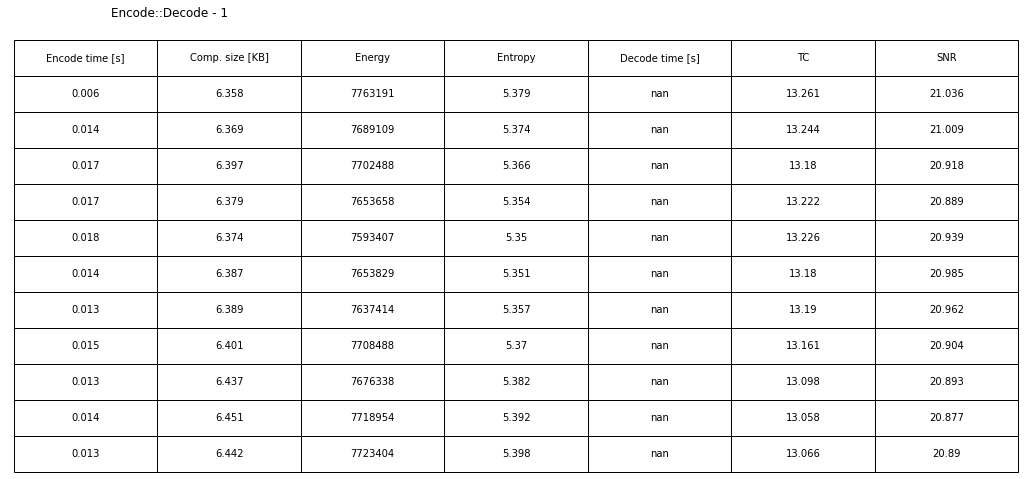

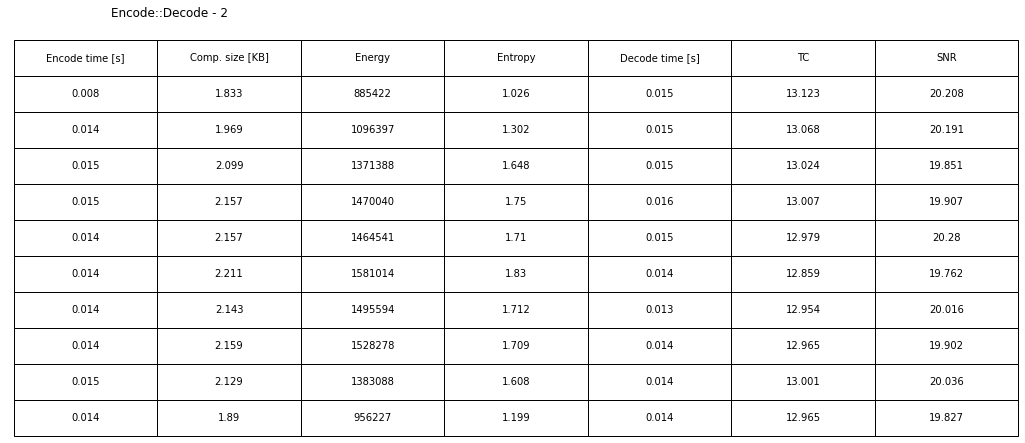

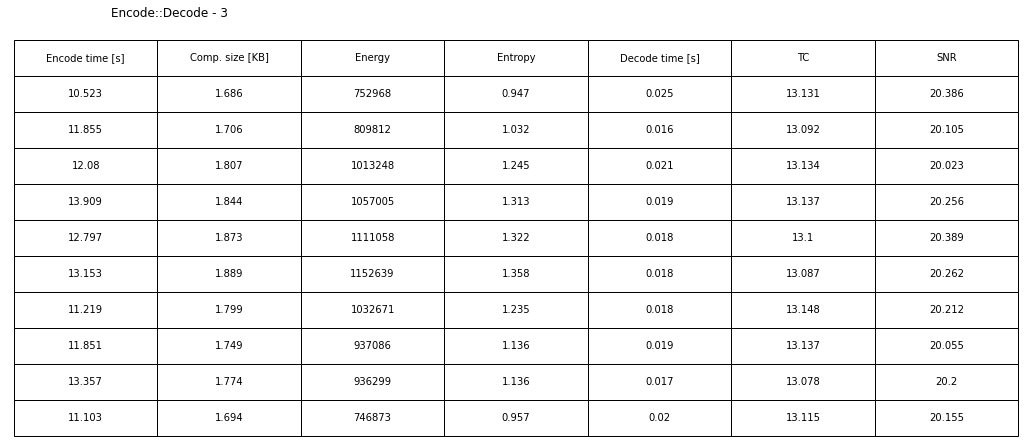

In [96]:
table_header = ['Encode time [s]','Comp. size [KB]', 'Energy', 'Entropy', 'Decode time [s]', 'TC', 'SNR']

# table data
table_data_1 = []
for i in range(len(frames)):
    table_data_1.append( 
        [round(encode_time_1[i],3), 
         round(compression_size_1[i]/1000,3),
         round(energy_1[i],3),
         round(entropy_1[i],3),
         round(decode_time_1[i],3),
         round(TC_1[i],3),
         round(SNR_1[i],3)])
    
table_data_2 = []
for i in range(len(Pframes2)):
    table_data_2.append( 
        [round(encode_time_2[i],3),
         round(compression_size_2[i]/1000,3),
         round(energy_2[i],3),
         round(entropy_2[i],3),
         round(decode_time_2[i],3),
         round(TC_2[i],3),
         round(SNR_2[i],3)])
    
table_data_3 = []
for i in range(len(Pframes3)):
    table_data_3.append( 
        [round(encode_time_3[i],3),
         round(compression_size_3[i]/1000,3),
         round(energy_3[i],3),
         round(entropy_3[i],3),
         round(decode_time_3[i],3),
         round(TC_3[i],3),
         round(SNR_3[i],3)])

# create tables
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

# build tables
table_1 = ax1.table(
    cellText=table_data_1, 
    colLabels=table_header, 
    cellLoc='center',
    loc ='upper left')

table_2 = ax2.table(
    cellText=table_data_2, 
    colLabels=table_header, 
    cellLoc='center',
    loc ='upper left')

table_3 = ax3.table(
    cellText=table_data_3, 
    colLabels=table_header, 
    cellLoc='center',
    loc ='upper left')

# hide the axes
fig1.patch.set_visible(False)
ax1.axis('off')
ax1.axis('tight')
fig2.patch.set_visible(False)
ax2.axis('off')
ax2.axis('tight')
fig3.patch.set_visible(False)
ax3.axis('off')
ax3.axis('tight')

# display tables
fig1.suptitle('Encode::Decode - 1')
table_1.scale(3,3)
fig2.suptitle('Encode::Decode - 2')
table_2.scale(3,3)
fig3.suptitle('Encode::Decode - 3')
table_3.scale(3,3)

plt.show()

<a id="graficos"></a>

## Gráficos

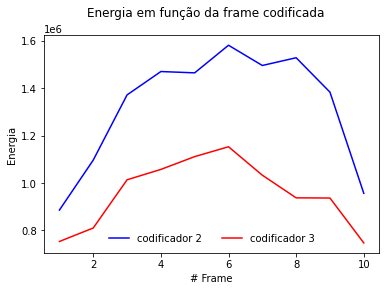

In [121]:
fig, ax = plt.subplots()
fig.suptitle('Energia em função da frame codificada')
ax.plot(list(range(1, 11)), energy_2,  'blue', label='codificador 2')
ax.plot(list(range(1, 11)), energy_3,  'red', label='codificador 3')
ax.legend(frameon=False, loc='lower center', ncol=2);
# plot display settings
plt.xlabel('# Frame')
plt.ylabel('Energia')
plt.show()

<a id="conclusoes"></a>

# Conclusões

Este trabalho explora os princípios básicos da codificação de vídeo, e foram implementados três formas de codificação de vídeo:
* considerando que cada frame é uma intra-frame
* considerando que todas as frames à exceção da primeira são inter-frames, sem compensação de movimento
* considerando que todas as frames à exceção da primeira são inter-frames, com compensação de movimento

Analisando os valores de entropia na [tabela](#tabela-analise-frame-a-frame), pode-se considerar que são valores óptimos, pois para qualquer um dos condificadores, demonstram ser possível realizar uma compressão sem perda, uma vez que o valor de entropia é menor que o número médio de bits por símbolo **H(S) < L**. O _codificador 3_ é o que apresenta melhor valor de entropia como seria de esperar, uma vez que as frames resultantes da codificação têm menos símbolos destintos (porque têm mais valores de zero).

O _codificador 3_, de todos os codificadores implementados é o que apresenta melhor taxa de compressão. Essêncialmente ele estima o movimento, determinado um vetor de movimento para compensar o erro entre uma frame de referência e a frame atual. Isto vai resultar numa imagem com muitos mais zeros quando comparado com os outros codificadores. Se a frame estimação for muito boa
o erro a transmitir é quase nulo e com baixa entropia, logo a sua codificação é mais eficiente.

Para as frames do trabalho, a codificação com compensação de movimento reduz o bit rate em mais de 10% quando comparado com a codificação baseada apenas na diferença entre frames. Não existe grande redução de bit rate para estas frames porque efetivamente as frames são todas muitos idênticas com a exeção de pequenos movimentos da bola de ping-pong e do braço do jogador.

![without-and-with-motion-compensation](./report/without-and-with-motion-compensation.png)

Em contrapartida, como seria de esperar, a codificação com compensação de movimento, é mais lenta devido à sua complexidade computacional. A codificação poderia ser mais célere se se utiliza-se outra estratégia de procura em vez da estratégica full-search, onde todos os deslocamentos possíveis dentro de uma janela de pesquisa são comparados. Por exemplo, uma estragégia de procura logarítimia 2D, tem como objetivo fazer uma pesquisa a'priori na direção horizontal e vertical para os extremos, que seriam os valores (segundo um critério, como o erro absoluto médio), de forma a definir uma janela de procura mais pequena.

Analisando o [gráfico](#graficos) que representa a energia em função da frame codificada, é notório que onde existe maior concentração de energia é nas frames intermédias (3-8). Isto acontece porque a frame "óptima" já se encontra fora da janela de procura, resultando numa imagem com o erro maior. Para resolver este problema, seria necessário utilizar outras frames de referência (Iframe) mais intercaladas, ao contrário do que acontece neste trabalho prático, onde se utiliza sempre a mesma.

As imagems são bem reconstruídas com qualquer um dos codificadores, resultando numa relação sinal ruído alta (potência do sinal > potência do ruído), obtendo-se como resultado uma boa resolução de imagem. Em contrapartida a taxa de compressão é mais baixa, pois elas são duas propriedades com proporcionalidade inversa.



In [102]:
imshow_with_movement_vector("motion-vector for frame 5", Iframe.copy(), full_search_result[5], 'yellow')

Na imagem seguinte é possível observar os movimentos de cada bloco na frame de referência (Iframe), para as suas novas posições, para criar uma imagem de compensação de movimento para a frame 5. 

![motion-vector-frame-5](./report/motion-vector-frame-5.png)

No final considera-se que se conseguiu implementar com sucesso todos os 3 codificadores listados no enunciado, compreendendo-se as mais valias de se utilizar um codificador com compensação de movimento, aliado com a técnica de compressão jpeg.

[back to index](#index)